<a href="https://colab.research.google.com/github/https-deeplearning-ai/GANs-Public/blob/master/C3W2_Pix2PixHD_(Optional).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pix2PixHD

*Please note that this is an optional notebook, meant to introduce more advanced concepts if you're up for a challenge, so don't worry if you don't completely follow!*

It is recommended that you should already be familiar with:
 - Residual blocks, from [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) (He et al. 2015)
 - Perceptual loss, from [Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://arxiv.org/abs/1603.08155) (Johnson et al. 2016)
 - VGG architecture, from [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556) (Simonyan et al. 2015)
 - Instance normalization (which you should know from StyleGAN), from [Instance Normalization: The Missing Ingredient for Fast Stylization](https://arxiv.org/abs/1607.08022) (Ulyanov et al. 2017)
 - Reflection padding, which Pytorch has implemented in [torch.nn.ReflectionPad2d](https://pytorch.org/docs/stable/generated/torch.nn.ReflectionPad2d.html)

**Goals**

In this notebook, you will learn about Pix2PixHD, which synthesizes high-resolution images from semantic label maps. Proposed in [High-Resolution Image Synthesis and Semantic Manipulation with Conditional GANs](https://arxiv.org/abs/1711.11585) (Wang et al. 2018), Pix2PixHD improves upon Pix2Pix via multiscale architecture, improved adversarial loss, and instance maps.

## Residual Blocks

The residual block, which is relevant in many state-of-the-art computer vision models, is used in all parts of Pix2PixHD. If you're not familiar with residual blocks, please take a look [here](https://paperswithcode.com/method/residual-block). Now, you'll start by first implementing a basic residual block.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    '''
    ResidualBlock Class
    Values
        channels: the number of channels throughout the residual block, a scalar
    '''

    def __init__(self, channels):
        super().__init__()

        self.layers = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, kernel_size=3, padding=0),
            nn.InstanceNorm2d(channels, affine=False),

            nn.ReLU(inplace=True),

            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, kernel_size=3, padding=0),
            nn.InstanceNorm2d(channels, affine=False),
        )

    def forward(self, x):
        return x + self.layers(x)

## Multiscale Generator: Generating at multiple scales (resolutions)

The Pix2PixHD generator is comprised of two separate subcomponent generators: $G_1$ is called the global generator and operates at low resolution (1024 x 512) to transfer styles. $G_2$ is the local enhancer and operates at high resolution (2048 x 1024) to deal with higher resolution.

The architecture for each network is adapted from [Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://arxiv.org/abs/1603.08155) (Johnson et al. 2016) and is comprised of

\begin{align*}
    G = \left[G^{(F)}, G^{(R)}, G^{(B)}\right],
\end{align*}

where $G^{(F)}$ is a frontend of convolutional blocks (downsampling), $G^{(R)}$ is a set of residual blocks, and $G^{(B)}$ is a backend of transposed convolutional blocks (upsampling). This is just a type of encoder-decoder generator that you learned about with Pix2Pix!

$G_1$ is trained first on low-resolution images. Then, $G_2$ is added to the pre-trained $G_1$ and both are trained jointly on high-resolution images. Specifically, $G_2^{(F)}$ encodes a high-resolution image, $G_1$ encodes a downsampled, low-resolution image, and the outputs from both are summed and passed sequentially to $G_2^{(R)}$ and $G_2^{(B)}$. This pre-training and fine-tuning scheme works well because the model is able to learn accurate coarser representations before using them to touch up its refined representations, since learning high-fidelity representations is generally a pretty hard task.

> ![Pix2PixHD Generator](https://drive.google.com/uc?export=view&id=1HDGPKupDxD52JSgnuH9pANV7hhHF3BDm)
*Pix2PixHD Generator, taken from Figure 3 of [High-Resolution Image Synthesis and Semantic Manipulation with Conditional GANs](https://arxiv.org/abs/1711.11585) (Wang et al. 2018). Following our notation, $G = \left[G_2^{(F)}, G_1^{(F)}, G_1^{(R)}, G_1^{(B)}, G_2^{(R)}, G_2^{(B)}\right]$ from left to right.*

### Global Subgenerator ($G_1$)

Let's first start by building the global generator ($G_1$). Even though the global generator is nested inside the local enhancer, you'll still need a separate module for training $G_1$ on its own first.

In [ ]:
class GlobalGenerator(nn.Module):
    '''
    GlobalGenerator Class:
    Implements the global subgenerator (G1) for transferring styles at lower resolutions.
    Values:
        in_channels: the number of input channels, a scalar
        out_channels: the number of output channels, a scalar
        base_channels: the number of channels in first convolutional layer, a scalar
        fb_blocks: the number of frontend / backend blocks, a scalar
        res_blocks: the number of residual blocks, a scalar
    '''

    def __init__(self, in_channels, out_channels,
                 base_channels=64, fb_blocks=3, res_blocks=9):
        super().__init__()

        # Initial convolutional layer
        g1 = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, base_channels, kernel_size=7, padding=0),
            nn.InstanceNorm2d(base_channels, affine=False),
            nn.ReLU(inplace=True),
        ]

        channels = base_channels
        # Frontend blocks
        for _ in range(fb_blocks):
            g1 += [
                nn.Conv2d(channels, 2 * channels, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(2 * channels, affine=False),
                nn.ReLU(inplace=True),
            ]
            channels *= 2

        # Residual blocks
        for _ in range(res_blocks):
            g1 += [ResidualBlock(channels)]

        # Backend blocks
        for _ in range(fb_blocks):
            g1 += [
                nn.ConvTranspose2d(channels, channels // 2, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(channels // 2, affine=False),
                nn.ReLU(inplace=True),
            ]
            channels //= 2

        # Output convolutional layer as its own nn.Sequential since it will be omitted in second training phase
        self.out_layers = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(base_channels, out_channels, kernel_size=7, padding=0),
            nn.Tanh(),
        )

        self.g1 = nn.Sequential(*g1)

    def forward(self, x):
        x = self.g1(x)
        x = self.out_layers(x)
        return x

### Local Enhancer Subgenerator ($G_2$)

And now onto the local enhancer ($G_2$)! Recall that the local enhancer uses (a pretrained) $G_1$ as part of its architecture. Following our earlier notation, recall that the residual connections from the last layers of $G_2^{(F)}$ and $G_1^{(B)}$ are added together and passed through $G_2^{(R)}$ and $G_2^{(B)}$ to synthesize a high-resolution image. Because of this, you should reuse the $G_1$ implementation so that the weights are consistent for the second training phase.

In [ ]:
class LocalEnhancer(nn.Module):
    '''
    LocalEnhancer Class:  
    Implements the local enhancer subgenerator (G2) for handling larger scale images.
    Values:
        in_channels: the number of input channels, a scalar
        out_channels: the number of output channels, a scalar
        base_channels: the number of channels in first convolutional layer, a scalar
        global_fb_blocks: the number of global generator frontend / backend blocks, a scalar
        global_res_blocks: the number of global generator residual blocks, a scalar
        local_res_blocks: the number of local enhancer residual blocks, a scalar
    '''

    def __init__(self, in_channels, out_channels, base_channels=32, global_fb_blocks=3, global_res_blocks=9, local_res_blocks=3):
        super().__init__()

        global_base_channels = 2 * base_channels

        # Downsampling layer for high-res -> low-res input to g1
        self.downsample = nn.AvgPool2d(3, stride=2, padding=1, count_include_pad=False)

        # Initialize global generator without its output layers
        self.g1 = GlobalGenerator(
            in_channels, out_channels, base_channels=global_base_channels, fb_blocks=global_fb_blocks, res_blocks=global_res_blocks,
        ).g1

        self.g2 = nn.ModuleList()

        # Initialize local frontend block
        self.g2.append(
            nn.Sequential(
                # Initial convolutional layer
                nn.ReflectionPad2d(3),
                nn.Conv2d(in_channels, base_channels, kernel_size=7, padding=0), 
                nn.InstanceNorm2d(base_channels, affine=False),
                nn.ReLU(inplace=True),

                # Frontend block
                nn.Conv2d(base_channels, 2 * base_channels, kernel_size=3, stride=2, padding=1), 
                nn.InstanceNorm2d(2 * base_channels, affine=False),
                nn.ReLU(inplace=True),
            )
        )

        # Initialize local residual and backend blocks
        self.g2.append(
            nn.Sequential(
                # Residual blocks
                *[ResidualBlock(2 * base_channels) for _ in range(local_res_blocks)],

                # Backend blocks
                nn.ConvTranspose2d(2 * base_channels, base_channels, kernel_size=3, stride=2, padding=1, output_padding=1), 
                nn.InstanceNorm2d(base_channels, affine=False),
                nn.ReLU(inplace=True),

                # Output convolutional layer
                nn.ReflectionPad2d(3),
                nn.Conv2d(base_channels, out_channels, kernel_size=7, padding=0),
                nn.Tanh(),
            )
        )

    def forward(self, x):
        # Get output from g1_B
        x_g1 = self.downsample(x)
        x_g1 = self.g1(x_g1)

        # Get output from g2_F
        x_g2 = self.g2[0](x)

        # Get final output from g2_B
        return self.g2[1](x_g1 + x_g2)

And voilà! You now have modules for both the global subgenerator and local enhancer subgenerator!

## Multiscale Discriminator: Discriminating at different scales too!

Pix2PixHD uses 3 separate subcomponents (subdiscriminators $D_1$, $D_2$, and $D_3$) to generate predictions. They all have the same architectures but $D_2$ and $D_3$ operate on inputs downsampled by 2x and 4x, respectively. The GAN objective is now modified as

\begin{align*}
    \min_G \max_{D_1,D_2,D_3}\sum_{k=1,2,3}\mathcal{L}_{\text{GAN}}(G, D_k)
\end{align*}

Each subdiscriminator is a PatchGAN, which you should be familiar with from Pix2Pix!

Let's first implement a single PatchGAN - this implementation will be slightly different than the one you saw in Pix2Pix since the intermediate feature maps will be needed for computing loss.

In [ ]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Implements the discriminator class for a subdiscriminator, 
    which can be used for all the different scales, just with different argument values.
    Values:
        in_channels: the number of channels in input, a scalar
        base_channels: the number of channels in first convolutional layer, a scalar
        n_layers: the number of convolutional layers, a scalar
    '''

    def __init__(self, in_channels, base_channels=64, n_layers=3):
        super().__init__()

        # Use nn.ModuleList so we can output intermediate values for loss.
        self.layers = nn.ModuleList()

        # Initial convolutional layer
        self.layers.append(
            nn.Sequential(
                nn.Conv2d(in_channels, base_channels, kernel_size=4, stride=2, padding=2),
                nn.LeakyReLU(0.2, inplace=True),
            )
        )

        # Downsampling convolutional layers
        channels = base_channels
        for _ in range(1, n_layers):
            prev_channels = channels
            channels = min(2 * channels, 512)
            self.layers.append(
                nn.Sequential(
                    nn.Conv2d(prev_channels, channels, kernel_size=4, stride=2, padding=2),
                    nn.InstanceNorm2d(channels, affine=False),
                    nn.LeakyReLU(0.2, inplace=True),
                )
            )

        # Output convolutional layer
        prev_channels = channels
        channels = min(2 * channels, 512)
        self.layers.append(
            nn.Sequential(
                nn.Conv2d(prev_channels, channels, kernel_size=4, stride=1, padding=2),
                nn.InstanceNorm2d(channels, affine=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(channels, 1, kernel_size=4, stride=1, padding=2),
            )
        )

    def forward(self, x):
        outputs = [] # for feature matching loss
        for layer in self.layers:
            x = layer(x)
            outputs.append(x)

        return outputs

Now you're ready to implement the multiscale discriminator in full! This puts together the different subdiscriminator scales.

In [ ]:
class MultiscaleDiscriminator(nn.Module):
    '''
    MultiscaleDiscriminator Class
    Values:
        in_channels: number of input channels to each discriminator, a scalar
        base_channels: number of channels in first convolutional layer, a scalar
        n_layers: number of downsampling layers in each discriminator, a scalar
        n_discriminators: number of discriminators at different scales, a scalar
    '''

    def __init__(self, in_channels, base_channels=64, n_layers=3, n_discriminators=3):
        super().__init__()

        # Initialize all discriminators
        self.discriminators = nn.ModuleList()
        for _ in range(n_discriminators):
            self.discriminators.append(
                Discriminator(in_channels, base_channels=base_channels, n_layers=n_layers)
            )

        # Downsampling layer to pass inputs between discriminators at different scales
        self.downsample = nn.AvgPool2d(3, stride=2, padding=1, count_include_pad=False)

    def forward(self, x):
        outputs = []

        for i, discriminator in enumerate(self.discriminators):
            # Downsample input for subsequent discriminators
            if i != 0:
                x = self.downsample(x)

            outputs.append(discriminator(x))

        # Return list of multiscale discriminator outputs
        return outputs

    @property
    def n_discriminators(self):
        return len(self.discriminators)

## Instance Boundary Map: Learning boundaries between instances

Here's a new method that adds additional information as conditional input!

The authors observed that previous approaches have typically taken in a label map (aka. segmentation map) that labels all the pixels to be of a certain class (i.e. car) but doesn't differentiate between two instances of the same class (i.e. two cars in the image). This is the difference between *semantic label maps*, which have class labels but not instance labels, and *instance label maps*, which represent unique instances with unique numbers.

The authors found that the most important information in the instance lelab map is actually the boundaries between instances (i.e. the outline of each car). You can create boundary maps by mapping each pixel maps to a 1 if it's a different instance from its 4 neighbors, and 0 otherwise.

To include this information, the authors concatenate the boundary map with the semantic label map as input. From the figure below, you can see that including both as input results in much sharper generated images (right) than only inputting the semantic label map (left).

> ![Semantic label map input vs instance boundary map input](https://drive.google.com/uc?export=view&id=18J9HN-_TJMYRHPWhygAbc7EVgxpgrl8H)
![Semantic label map vs instance boundary map](https://drive.google.com/uc?export=view&id=13_lT1DPUxEwWWyjf-aXGzom_D4BFze2E)
*Semantic label map input (top left) and its blurry output between instances (bottom left) vs. instance boundary map (top right) and the much clearer output between instances from inputting both the semantic label map and the instance boundary map (bottom right). Taken from Figures 4 and 5 of [High-Resolution Image Synthesis and Semantic Manipulation with Conditional GANs](https://arxiv.org/abs/1711.11585) (Wang et al. 2018).*

## Instance-level Feature Encoder: Adding controllable diversity

As you already know, the task of generation has more than one possible realistic output. For example, an object of class `road` could be concrete, cobblestone, dirt, etc. To learn this diversity, the authors introduce an encoder $E$, which takes the original image as input and outputs a feature map (like the feature extractor from Course 2, Week 1). They apply *instance-wise averaging*, averaging the feature vectors across all occurrences of each instance  (so that every pixel corresponding to the same instance has the same feature vector). They then concatenate this instance-level feature embedding with the semantic label and instance boundary maps as input to the generator.

What's cool is that the encoder $E$ is trained jointly with $G_1$. One huge backprop! When training $G_2$, $E$ is fed a downsampled image and the corresponding output is upsampled to pass into $G_2$.

To allow for control over different features (e.g. concrete, cobblestone, and dirt) for inference, the authors first use K-means clustering to cluster all the feature vectors for each object class in the training set. You can think of this as a dictionary, mapping each class label to a set of feature vectors (so $K$ centroids, each representing different clusters of features). Now during inference, you can perform a random lookup from this dictionary for each class (e.g. road) in the semantic label map to generate one type of feature (e.g. dirt). To provide greater control, you can select among different feature types for each class to generate diverse feature types and, as a result, multi-modal outputs from the same input. 

Higher values of $K$ increase diversity and potentially decrease fidelity. You've seen this tradeoff between diversity and fidelity before with the truncation trick, and this is just another way to trade-off between them.


In [ ]:
class Encoder(nn.Module):
    '''
    Encoder Class
    Values:
        in_channels: number of input channels to each discriminator, a scalar
        out_channels: number of channels in output feature map, a scalar
        base_channels: number of channels in first convolutional layer, a scalar
        n_layers: number of downsampling layers, a scalar
    '''

    def __init__(self, in_channels, out_channels, base_channels=16, n_layers=4):
        super().__init__()

        self.out_channels = out_channels
        channels = base_channels

        layers = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, base_channels, kernel_size=7, padding=0), 
            nn.InstanceNorm2d(base_channels),
            nn.ReLU(inplace=True),
        ]

        # Downsampling layers
        for i in range(n_layers):
            layers += [
                nn.Conv2d(channels, 2 * channels, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(2 * channels),
                nn.ReLU(inplace=True),
            ]
            channels *= 2
    
        # Upsampling layers
        for i in range(n_layers):
            layers += [
                nn.ConvTranspose2d(channels, channels // 2, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(channels // 2),
                nn.ReLU(inplace=True),
            ]
            channels //= 2

        layers += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(base_channels, out_channels, kernel_size=7, padding=0),
            nn.Tanh(),
        ]

        self.layers = nn.Sequential(*layers)

    def instancewise_average_pooling(self, x, inst):
        '''
        Applies instance-wise average pooling.

        Given a feature map of size (b, c, h, w), the mean is computed for each b, c
        across all h, w of the same instance
        '''
        x_mean = torch.zeros_like(x)
        classes = torch.unique(inst, return_inverse=False, return_counts=False) # gather all unique classes present

        for i in classes:
            for b in range(x.size(0)):
                indices = torch.nonzero(inst[b:b+1] == i, as_tuple=False) # get indices of all positions equal to class i
                for j in range(self.out_channels):
                    x_ins = x[indices[:, 0] + b, indices[:, 1] + j, indices[:, 2], indices[:, 3]]
                    mean_feat = torch.mean(x_ins).expand_as(x_ins)
                    x_mean[indices[:, 0] + b, indices[:, 1] + j, indices[:, 2], indices[:, 3]] = mean_feat

        return x_mean

    def forward(self, x, inst):
        x = self.layers(x)
        x = self.instancewise_average_pooling(x, inst)
        return x

## Additional Loss Functions

In addition to the architectural and feature-map enhancements, the authors also incorporate a feature matching loss based on the discriminator. Essentially, they output intermediate feature maps at different resolutions from the discriminator and try to minimize the difference between the real and fake image features.

The authors found this to stabilize training. In this case, this forces the generator to produce natural statistics at multiple scales. This feature-matching loss is similar to StyleGAN's perceptual loss. For some semantic label map $s$ and corresponding image $x$,

\begin{align*}
    \mathcal{L}_{\text{FM}} = \mathbb{E}_{s,x}\left[\sum_{i=1}^T\dfrac{1}{N_i}\left|\left|D^{(i)}_k(s, x) - D^{(i)}_k(s, G(s))\right|\right|_1\right]
\end{align*}

where $T$ is the total number of layers, $N_i$ is the number of elements at layer $i$, and $D^{(i)}_k$ denotes the $i$th layer in discriminator $k$.

The authors also report minor improvements in performance when adding perceptual loss, formulated as

\begin{align*}
    \mathcal{L}_{\text{VGG}} = \mathbb{E}_{s,x}\left[\sum_{i=1}^N\dfrac{1}{M_i}\left|\left|F^i(x) - F^i(G(s))\right|\right|_1\right]
\end{align*}

where $F^i$ denotes the $i$th layer with $M_i$ elements of the VGG19 network. `torchvision` provides a pretrained VGG19 network, so you'll just need a simple wrapper for it to get the intermediate outputs.

The overall loss looks like this:

\begin{align*}
    \mathcal{L} = \mathcal{L}_{\text{GAN}} + \lambda_1\mathcal{L}_{\text{FM}} + \lambda_2\mathcal{L}_{\text{VGG}}
\end{align*}

where $\lambda_1 = \lambda_2 = 10$.

In [ ]:
import torchvision.models as models

class VGG19(nn.Module):
    '''
    VGG19 Class
    Wrapper for pretrained torchvision.models.vgg19 to output intermediate feature maps
    '''

    def __init__(self):
        super().__init__()
        vgg_features = models.vgg19(pretrained=True).features

        self.f1 = nn.Sequential(*[vgg_features[x] for x in range(2)])
        self.f2 = nn.Sequential(*[vgg_features[x] for x in range(2, 7)])
        self.f3 = nn.Sequential(*[vgg_features[x] for x in range(7, 12)])
        self.f4 = nn.Sequential(*[vgg_features[x] for x in range(12, 21)])
        self.f5 = nn.Sequential(*[vgg_features[x] for x in range(21, 30)])

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        h1 = self.f1(x)
        h2 = self.f2(h1)
        h3 = self.f3(h2)
        h4 = self.f4(h3)
        h5 = self.f5(h4)
        return [h1, h2, h3, h4, h5]

class Loss(nn.Module):
    '''
    Loss Class
    Implements composite loss for GauGAN
    Values:
        lambda1: weight for feature matching loss, a float
        lambda2: weight for vgg perceptual loss, a float
        device: 'cuda' or 'cpu' for hardware to use
        norm_weight_to_one: whether to normalize weights to (0, 1], a bool
    '''

    def __init__(self, lambda1=10., lambda2=10., device='cuda', norm_weight_to_one=True):
        super().__init__()
        self.vgg = VGG19().to(device)
        self.vgg_weights = [1.0/32, 1.0/16, 1.0/8, 1.0/4, 1.0]

        lambda0 = 1.0
        # Keep ratio of composite loss, but scale down max to 1.0
        scale = max(lambda0, lambda1, lambda2) if norm_weight_to_one else 1.0

        self.lambda0 = lambda0 / scale
        self.lambda1 = lambda1 / scale
        self.lambda2 = lambda2 / scale

    def adv_loss(self, discriminator_preds, is_real):
        '''
        Computes adversarial loss from nested list of fakes outputs from discriminator.
        '''
        target = torch.ones_like if is_real else torch.zeros_like

        adv_loss = 0.0
        for preds in discriminator_preds:
            pred = preds[-1]
            adv_loss += F.mse_loss(pred, target(pred))
        return adv_loss

    def fm_loss(self, real_preds, fake_preds):
        '''
        Computes feature matching loss from nested lists of fake and real outputs from discriminator.
        '''
        fm_loss = 0.0
        for real_features, fake_features in zip(real_preds, fake_preds):
            for real_feature, fake_feature in zip(real_features, fake_features):
                fm_loss += F.l1_loss(real_feature.detach(), fake_feature)
        return fm_loss

    def vgg_loss(self, x_real, x_fake):
        '''
        Computes perceptual loss with VGG network from real and fake images.
        '''
        vgg_real = self.vgg(x_real)
        vgg_fake = self.vgg(x_fake)

        vgg_loss = 0.0
        for real, fake, weight in zip(vgg_real, vgg_fake, self.vgg_weights):
            vgg_loss += weight * F.l1_loss(real.detach(), fake)
        return vgg_loss

    def forward(self, x_real, label_map, instance_map, boundary_map, encoder, generator, discriminator):
        '''
        Function that computes the forward pass and total loss for generator and discriminator.
        '''
        feature_map = encoder(x_real, instance_map)
        x_fake = generator(torch.cat((label_map, boundary_map, feature_map), dim=1))

        # Get necessary outputs for loss/backprop for both generator and discriminator
        fake_preds_for_g = discriminator(torch.cat((label_map, boundary_map, x_fake), dim=1))
        fake_preds_for_d = discriminator(torch.cat((label_map, boundary_map, x_fake.detach()), dim=1))
        real_preds_for_d = discriminator(torch.cat((label_map, boundary_map, x_real.detach()), dim=1))

        g_loss = (
            self.lambda0 * self.adv_loss(fake_preds_for_g, False) + \
            self.lambda1 * self.fm_loss(real_preds_for_d, fake_preds_for_g) / discriminator.n_discriminators + \
            self.lambda2 * self.vgg_loss(x_fake, x_real)
        )
        d_loss = 0.5 * (
            self.adv_loss(real_preds_for_d, True) + \
            self.adv_loss(fake_preds_for_d, False)
        )

        return g_loss, d_loss, x_fake.detach()

## Training Pix2PixHD

You now have the Pix2PixHD model coded up! All you have to do now is prepare your dataset. Pix2PixHD is trained on the Cityscapes dataset, which unfortunately requires registration. You'll have to download the dataset and put it in your `data` folder to initialize the dataset code below.

Specifically, you should download the `gtFine_trainvaltest` and `leftImg8bit_trainvaltest` and specify the corresponding data splits into the dataloader.

In [ ]:
import os

import numpy as np
import torchvision.transforms as transforms
from PIL import Image

def scale_width(img, target_width, method):
    '''
    Function that scales an image to target_width while retaining aspect ratio.
    '''
    w, h = img.size
    if w == target_width: return img
    target_height = target_width * h // w
    return img.resize((target_width, target_height), method)

class CityscapesDataset(torch.utils.data.Dataset):
    '''
    CityscapesDataset Class
    Values:
        paths: (a list of) paths to load examples from, a list or string
        target_width: the size of image widths for resizing, a scalar
        n_classes: the number of object classes, a scalar
    '''

    def __init__(self, paths, target_width=1024, n_classes=35):
        super().__init__()

        self.n_classes = n_classes

        # Collect list of examples
        self.examples = {}
        if type(paths) == str:
            self.load_examples_from_dir(paths)
        elif type(paths) == list:
            for path in paths:
                self.load_examples_from_dir(path)
        else:
            raise ValueError('`paths` should be a single path or list of paths')

        self.examples = list(self.examples.values())
        assert all(len(example) == 3 for example in self.examples)

        # Initialize transforms for the real color image
        self.img_transforms = transforms.Compose([
            transforms.Lambda(lambda img: scale_width(img, target_width, Image.BICUBIC)),
            transforms.Lambda(lambda img: np.array(img)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

        # Initialize transforms for semantic label and instance maps
        self.map_transforms = transforms.Compose([
            transforms.Lambda(lambda img: scale_width(img, target_width, Image.NEAREST)),
            transforms.Lambda(lambda img: np.array(img)),
            transforms.ToTensor(),
        ])

    def load_examples_from_dir(self, abs_path):
        '''
        Given a folder of examples, this function returns a list of paired examples.
        '''
        assert os.path.isdir(abs_path)

        img_suffix = '_leftImg8bit.png'
        label_suffix = '_gtFine_labelIds.png'
        inst_suffix = '_gtFine_instanceIds.png'

        for root, _, files in os.walk(abs_path):
            for f in files:
                if f.endswith(img_suffix):
                    prefix = f[:-len(img_suffix)]
                    attr = 'orig_img'
                elif f.endswith(label_suffix):
                    prefix = f[:-len(label_suffix)]
                    attr = 'label_map'
                elif f.endswith(inst_suffix):
                    prefix = f[:-len(inst_suffix)]
                    attr = 'inst_map'
                else:
                    continue

                if prefix not in self.examples.keys():
                    self.examples[prefix] = {}
                self.examples[prefix][attr] = root + '/' + f

    def __getitem__(self, idx):
        example = self.examples[idx]

        # Load image and maps
        img = Image.open(example['orig_img']).convert('RGB') # color image: (3, 512, 1024)
        inst = Image.open(example['inst_map'])               # instance map: (512, 1024)
        label = Image.open(example['label_map'])             # semantic label map: (512, 1024)

        # Apply corresponding transforms
        img = self.img_transforms(img)
        inst = self.map_transforms(inst)
        label = self.map_transforms(label).long() * 255

        # Convert labels to one-hot vectors
        label = torch.zeros(self.n_classes, img.shape[1], img.shape[2]).scatter_(0, label, 1.0).to(img.dtype)

        # Convert instance map to instance boundary map
        bound = torch.ByteTensor(inst.shape).zero_()
        bound[:, :, 1:] = bound[:, :, 1:] | (inst[:, :, 1:] != inst[:, :, :-1])
        bound[:, :, :-1] = bound[:, :, :-1] | (inst[:, :, 1:] != inst[:, :, :-1])
        bound[:, 1:, :] = bound[:, 1:, :] | (inst[:, 1:, :] != inst[:, :-1, :])
        bound[:, :-1, :] = bound[:, :-1, :] | (inst[:, 1:, :] != inst[:, :-1, :])
        bound = bound.to(img.dtype)

        return (img, label, inst, bound)

    def __len__(self):
        return len(self.examples)

    @staticmethod
    def collate_fn(batch):
        imgs, labels, insts, bounds = [], [], [], []
        for (x, l, i, b) in batch:
            imgs.append(x)
            labels.append(l)
            insts.append(i)
            bounds.append(b)
        return (
            torch.stack(imgs, dim=0),
            torch.stack(labels, dim=0),
            torch.stack(insts, dim=0),
            torch.stack(bounds, dim=0),
        )

Now initialize everything you'll need for training. Don't be worried if there looks like a lot of random code, it's all stuff you've seen before!

In [ ]:
from tqdm import tqdm
from torch.utils.data import DataLoader

n_classes = 35                  # total number of object classes
rgb_channels = n_features = 3
device = 'cuda'
train_dir = ['data']
epochs = 200                    # total number of train epochs
decay_after = 100               # number of epochs with constant lr
lr = 0.0002
betas = (0.5, 0.999)

def lr_lambda(epoch):
    ''' Function for scheduling learning '''
    return 1. if epoch < decay_after else 1 - float(epoch - decay_after) / (epochs - decay_after)

def weights_init(m):
    ''' Function for initializing all model weights '''
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0., 0.02)

loss_fn = Loss(device=device)

## Phase 1: Low Resolution (1024 x 512)
dataloader1 = DataLoader(
    CityscapesDataset(train_dir, target_width=1024, n_classes=n_classes),
    collate_fn=CityscapesDataset.collate_fn, batch_size=1, shuffle=True, drop_last=False, pin_memory=True,
)
encoder = Encoder(rgb_channels, n_features).to(device).apply(weights_init)
generator1 = GlobalGenerator(n_classes + n_features + 1, rgb_channels).to(device).apply(weights_init)
discriminator1 = MultiscaleDiscriminator(n_classes + 1 + rgb_channels, n_discriminators=2).to(device).apply(weights_init)

g1_optimizer = torch.optim.Adam(list(generator1.parameters()) + list(encoder.parameters()), lr=lr, betas=betas)
d1_optimizer = torch.optim.Adam(list(discriminator1.parameters()), lr=lr, betas=betas)
g1_scheduler = torch.optim.lr_scheduler.LambdaLR(g1_optimizer, lr_lambda)
d1_scheduler = torch.optim.lr_scheduler.LambdaLR(d1_optimizer, lr_lambda)


## Phase 2: High Resolution (2048 x 1024)
dataloader2 = DataLoader(
    CityscapesDataset(train_dir, target_width=2048, n_classes=n_classes),
    collate_fn=CityscapesDataset.collate_fn, batch_size=1, shuffle=True, drop_last=False, pin_memory=True,
)
generator2 = LocalEnhancer(n_classes + n_features + 1, rgb_channels).to(device).apply(weights_init)
discriminator2 = MultiscaleDiscriminator(n_classes + 1 + rgb_channels).to(device).apply(weights_init)

g2_optimizer = torch.optim.Adam(list(generator2.parameters()) + list(encoder.parameters()), lr=lr, betas=betas)
d2_optimizer = torch.optim.Adam(list(discriminator2.parameters()), lr=lr, betas=betas)
g2_scheduler = torch.optim.lr_scheduler.LambdaLR(g2_optimizer, lr_lambda)
d2_scheduler = torch.optim.lr_scheduler.LambdaLR(d2_optimizer, lr_lambda)

And now the training loop, which is pretty much the same between the two phases:

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Parse torch version for autocast
# ######################################################
version = torch.__version__
version = tuple(int(n) for n in version.split('.')[:-1])
has_autocast = version >= (1, 6)
# ######################################################

def show_tensor_images(image_tensor):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:1], nrow=1)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def train(dataloader, models, optimizers, schedulers, device):
    encoder, generator, discriminator = models
    g_optimizer, d_optimizer = optimizers
    g_scheduler, d_scheduler = schedulers

    cur_step = 0
    display_step = 100

    mean_g_loss = 0.0
    mean_d_loss = 0.0

    for epoch in range(epochs):
        # Training epoch
        for (x_real, labels, insts, bounds) in tqdm(dataloader, position=0):
            x_real = x_real.to(device)
            labels = labels.to(device)
            insts = insts.to(device)
            bounds = bounds.to(device)

            # Enable autocast to FP16 tensors (new feature since torch==1.6.0)
            # If you're running older versions of torch, comment this out
            # and use NVIDIA apex for mixed/half precision training
            if has_autocast:
                with torch.cuda.amp.autocast(enabled=(device=='cuda')):
                    g_loss, d_loss, x_fake = loss_fn(
                        x_real, labels, insts, bounds, encoder, generator, discriminator
                    )
            else:
                g_loss, d_loss, x_fake = loss_fn(
                    x_real, labels, insts, bounds, encoder, generator, discriminator
                )

            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            mean_g_loss += g_loss.item() / display_step
            mean_d_loss += d_loss.item() / display_step

            if cur_step % display_step == 0 and cur_step > 0:
                print('Step {}: Generator loss: {:.5f}, Discriminator loss: {:.5f}'
                      .format(cur_step, mean_g_loss, mean_d_loss))
                show_tensor_images(x_fake.to(x_real.dtype))
                show_tensor_images(x_real)
                mean_g_loss = 0.0
                mean_d_loss = 0.0
            cur_step += 1

        g_scheduler.step()
        d_scheduler.step()

And now you can train your models! Remember to set the local enhancer subgenerator to the global subgenerator that you train in the first phase.

In their official repository, the authors don't continue to train the encoder. Instead, they precompute all feature maps upsample them, and concatenate this to the input to the local enhancer subgenerator. (They also leave a re-train option for it). For simplicity, the script below will just downsample and upsample high-resolution inputs.

In [ ]:
# Phase 1: Low Resolution
#######################################################################
train(
    dataloader1,
    [encoder, generator1, discriminator1],
    [g1_optimizer, d1_optimizer],
    [g1_scheduler, d1_scheduler],
    device,
)


# Phase 2: High Resolution
#######################################################################
# Update global generator in local enhancer with trained
generator2.g1 = generator1.g1

# Freeze encoder and wrap to support high-resolution inputs/outputs
def freeze(encoder):
    encoder.eval()
    for p in encoder.parameters():
        p.requires_grad = False

    @torch.jit.script
    def forward(x, inst):
        x = F.interpolate(x, scale_factor=0.5, recompute_scale_factor=True)
        inst = F.interpolate(inst.float(), scale_factor=0.5, recompute_scale_factor=True)
        feat = encoder(x, inst.int())
        return F.interpolate(feat, scale_factor=2.0, recompute_scale_factor=True)
    return forward

train(
    dataloader2,
    [freeze(encoder), generator2, discriminator2],
    [g2_optimizer, d2_optimizer],
    [g2_scheduler, d2_scheduler],
    device,
)

## Inference with Pix2PixHD

Recall that in inference time, the encoder feature maps from training are saved and clustered with K-means by object class. Again, you'll have to download the Cityscapes dataset into your `data` folder and then run these functions.

In [ ]:
from sklearn.cluster import KMeans

# Encode features by class label
features = {}
for (x, _, inst, _) in tqdm(dataloader2):
    x = x.to(device)
    inst = inst.to(device)
    area = inst.size(2) * inst.size(3)

    # Get pooled feature map
    with torch.no_grad():
        feature_map = encoder(x, inst)

    for i in torch.unique(inst):
        label = i if i < 1000 else i // 1000
        label = int(label.flatten(0).item())

        # All indices should have same feature per class from pooling
        idx = torch.nonzero(inst == i, as_tuple=False)
        n_inst = idx.size(0)
        idx = idx[0, :]

        # Retrieve corresponding encoded feature
        feature = feature_map[idx[0], :, idx[2], idx[3]].unsqueeze(0)

        # Compute rate of feature appearance (in official code, they compute per block)
        block_size = 32
        rate_per_block = 32 * n_inst / area
        rate = torch.ones((1, 1), device=device).to(feature.dtype) * rate_per_block

        feature = torch.cat((feature, rate), dim=1)
        if label in features.keys():
            features[label] = torch.cat((features[label], feature), dim=0)
        else:
            features[label] = feature


# Cluster features by class label
k = 10
centroids = {}
for label in range(n_classes):
    if label not in features.keys():
        continue
    feature = features[label]

    # Thresholding by 0.5 isn't mentioned in the paper, but is present in the
    # official code repository, probably so that only frequent features are clustered
    feature = feature[feature[:, -1] > 0.5, :-1].cpu().numpy()

    if feature.shape[0]:
        n_clusters = min(feature.shape[0], k)
        kmeans = KMeans(n_clusters=n_clusters).fit(feature)
        centroids[label] = kmeans.cluster_centers_

100%|██████████| 174/174 [02:07<00:00,  1.36it/s]


SyntaxError: ignored

After getting the encoded feature centroids per class, you can now run inference! Remember that the generator is trained to take in a concatenation of the semantic label map, instance boundary map, and encoded feature map.

Congrats on making it to the end of this complex notebook! Have fun with this powerful model and be responsible of course ;)

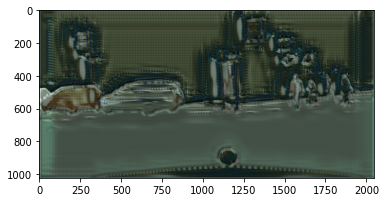

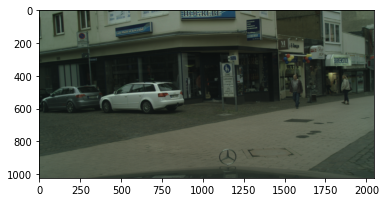

In [ ]:
def infer(label_map, instance_map, boundary_map):
    # Sample feature vector centroids
    b, _, h, w = label_map.shape
    feature_map = torch.zeros((b, n_features, h, w), device=device).to(label_map.dtype)

    for i in torch.unique(instance_map):
        label = i if i < 1000 else i // 1000
        label = int(label.flatten(0).item())

        if label in centroids.keys():
            centroid_idx = random.randint(0, centroids[label].shape[0] - 1)
            idx = torch.nonzero(instance_map == int(i), as_tuple=False)

            feature = torch.from_numpy(centroids[label][centroid_idx, :]).to(device)
            feature_map[idx[:, 0], :, idx[:, 2], idx[:, 3]] = feature

    with torch.no_grad():
        x_fake = generator2(torch.cat((label_map, boundary_map, feature_map), dim=1))
    return x_fake

for x, labels, insts, bounds in dataloader2:
    x_fake = infer(labels.to(device), insts.to(device), bounds.to(device))
    show_tensor_images(x_fake.to(x.dtype))
    show_tensor_images(x)
    break